# Dropout Produces Sparse Representations in an MNIST Autoencoder

This notebook replicates a few results from [Srivastava et al. 2014](http://www.jmlr.org/papers/volume15/srivastava14a.old/source/srivastava14a.pdf).

In particular, we focus on the sparsification properties of DropOut, and the resulting learned filters.

The key result to be replicated appears below.

Images of example outputs from this notebook appear in the `Replicating Dropout 2014/` subfolder of `img/`.

<img src="./img/srivastava.png">

#### Hyperparameter Settings

All networks have a single hidden layer of size 256. The inputs are of size $28\cdot28=784$. The networks have a rectifying nonlinearity. Weights are initialized from a truncated normal distribution and biases are initialized to a slightly negative value. All networks are trained using Nesterov momentum.

Hyperparameters were selected using grid search with human guidance.

In [1]:
%env CUDA_VISIBLE_DEVICES=1
# above line is specific to the Redwood cluster.
# shouldn't hurt, but feel free to comment out

import tensorflow as tf
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt

## seaborn has nice default styles, if you have it installed
# import seaborn as sns
# sns.set_style("whitegrid", {'axes.grid' : False})

plt.rcParams['image.cmap'] = 'Greys'

import utils.Autoencoder as AE
import utils.plotFunks as pF

%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


/home/charlesfrye/base/lib/python3.4/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#load in the mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


#### Recommended Values

The two hyperparameters to adjust are `dropout_rate`, which determines the average fraction of units that are dropped on each run, and `weight_decay_rate`, which determines the strength of the $\ell_2$-norm cost on the weights. The values below are a good place to start.

1. `weight_decay_rate=0.01` or `0.0`
1. `dropout_rate=0.5` or `0.0`

Epoch:  0001 	 test cost= 0.019942705 	 val cost= 0.019533584 	


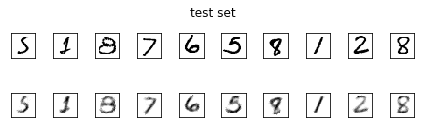

In [4]:
hyperparameters = AE.createHP_Dict(dropout_rate=0.5,weight_decay_rate=0.0)

graph, initializer, input_variable, weights, biases, encode_op, output_op, all_layer_ops, \
            keep_prob, optimizer, cost, saver = AE.setup(hyperparameters)

training_hyperparameters = {'batch_size':hyperparameters['batch_size'],
                            'dropout_rate':hyperparameters['dropout_rate'],
                            'num_epochs':1,
                            'display_every':2,
                            'show_final':True,
                           'output_folder':None,
                           }



modelFilePath, final_weights,final_biases = AE.train(graph, initializer, input_variable, weights, biases,
                                              output_op, keep_prob, optimizer, cost, saver, mnist, training_hyperparameters)

### Reconstruct `numExamples` digits from validation set and display random example

In [5]:
recons = AE.getReconstructions(graph,input_variable,output_op,saver,modelFilePath,mnist,numExamples=100)

INFO:tensorflow:Restoring parameters from models/lastRun/model


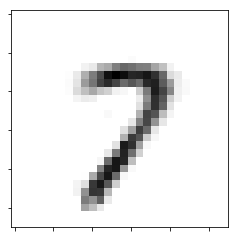

In [6]:
randomIdx = np.random.randint(0,len(recons))

pF.displayReconstruction(recons[randomIdx]);

### Calculate hidden unit responses and Display Statistics

In [7]:
activations = AE.getActivations(graph,input_variable,encode_op,saver,modelFilePath,mnist)

INFO:tensorflow:Restoring parameters from models/lastRun/model


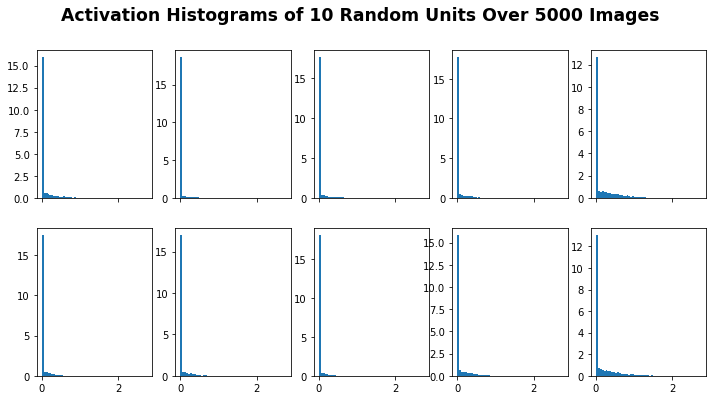

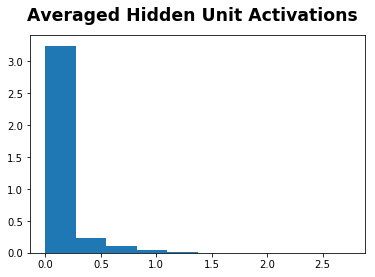

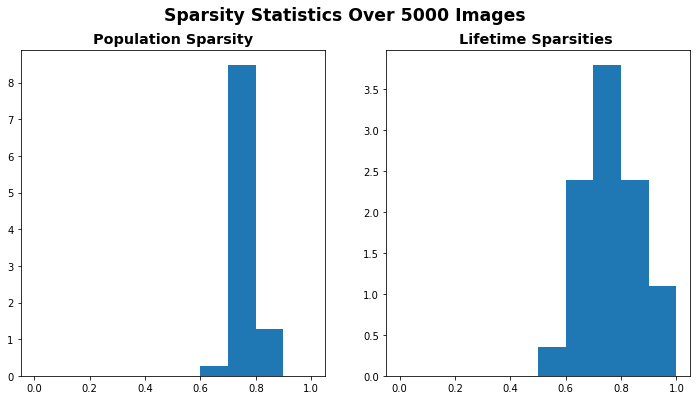

In [8]:
pF.plotRandomUnitActivations(activations)

pF.plotUnitActivations(activations)

pF.plotSparsityStatistics(activations)

The population sparsity is the fraction of units active in response to a given stimulus. The population sparsity histogram, therefore, is accumulated across trials.

The lifetime sparsity is the fraction of stimuli to which a unit responds. The lifetime sparsity histogram, therefore, is accumulated across units.

In [9]:
weights = AE.retrieveWeights(graph,saver,modelFilePath)

INFO:tensorflow:Restoring parameters from models/lastRun/model


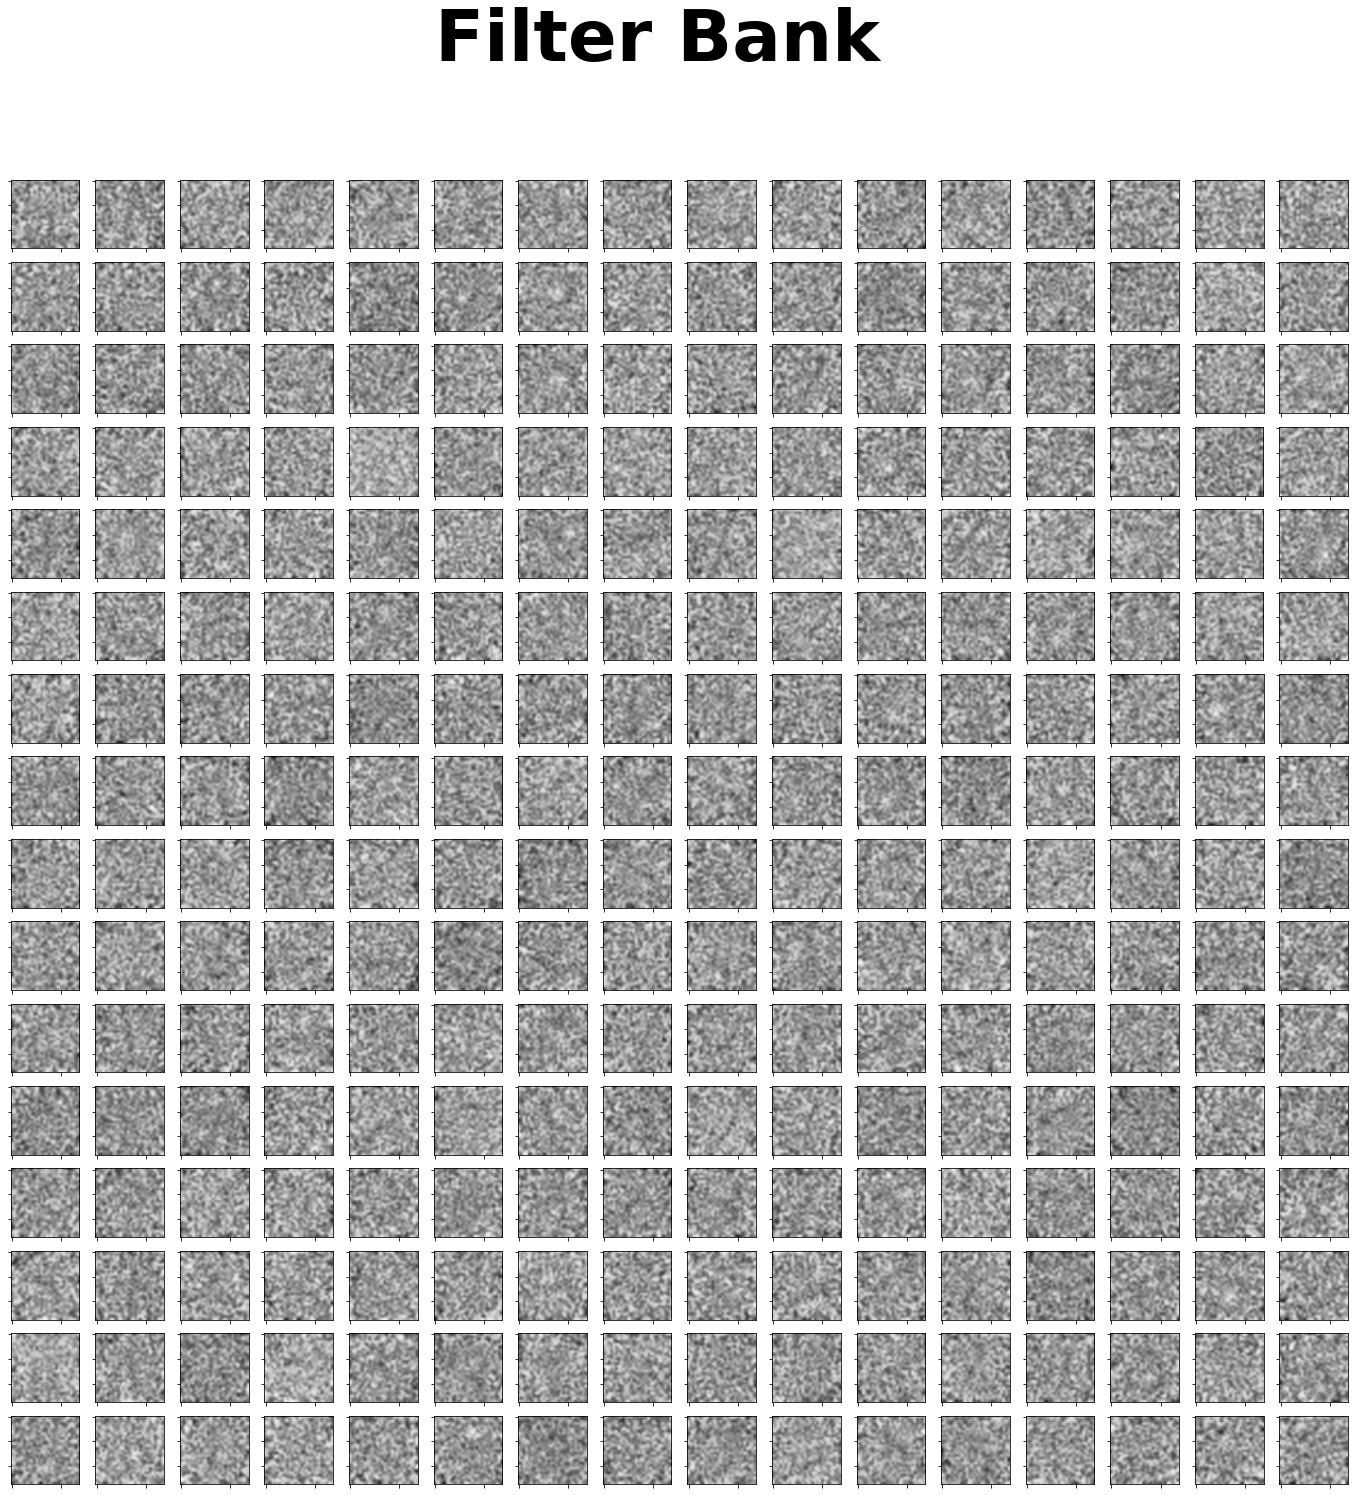

In [10]:
pF.plotFilterBank(weights)